In [61]:
import os
import shutil
import random
from pathlib import Path

# --- 1. Configuration ---
# Define source directories in a dictionary for easy iteration
source_dirs = {
    "sunny": "./data/sunny",
    "cloudy": "./data/cloudy",
    "rainy": "./data/rainy",
    "snowy": "./data/snowy",
    "foggy": "./data/foggy",
}

# Define base destination directories
base_train_dir = Path("./data/weather_train")
base_valid_dir = Path("./data/weather_validation")
base_test_dir = Path("./data/weather_test")

# Define split percentages for train, validation, and test sets
train_pct = 0.70
validation_pct = 0.15
test_pct = 0.15

# --- 2. Setup Directories ---
# Clean and create the directory structure
for base_dir in [base_train_dir, base_valid_dir, base_test_dir]:
    if base_dir.exists():
        shutil.rmtree(base_dir)
    # Create the base directory and all subdirectories for each weather type
    for weather_type in source_dirs.keys():
        os.makedirs(base_dir / weather_type, exist_ok=True)


# --- 3. Split and Copy Files ---
def copy_images(source_path, dest_path, image_files):
    """Copies a list of image files from a source to a destination."""
    for image in image_files:
        shutil.copyfile(source_path / image, dest_path / image)


# Loop through each weather type
for weather_type, source_path_str in source_dirs.items():
    source_path = Path(source_path_str)
    print(f"\nProcessing images for '{weather_type}'...")

    # 1. Get the list of images for the CURRENT category first.
    all_images = os.listdir(source_path)
    random.shuffle(all_images)  # Shuffle the list for a random split.

    # 2. Now, calculate split sizes based on the correct total.
    total_images = len(all_images)
    train_amount = int(total_images * train_pct)
    validation_amount = int(total_images * validation_pct)
    # The rest go to the test set to handle any rounding issues
    test_amount = total_images - train_amount - validation_amount

    # 3. Define non-overlapping slices from the shuffled list.
    train_split = all_images[:train_amount]
    valid_split = all_images[train_amount : train_amount + validation_amount]
    test_split = all_images[train_amount + validation_amount :]

    # Copy files to their respective destinations
    copy_images(source_path, base_train_dir / weather_type, train_split)
    copy_images(source_path, base_valid_dir / weather_type, valid_split)
    copy_images(source_path, base_test_dir / weather_type, test_split)

    print(f"  Total images: {total_images}")
    print(f"  Copied {len(train_split)} images to training set.")
    print(f"  Copied {len(valid_split)} images to validation set.")
    print(f"  Copied {len(test_split)} images to test set.")

print("\nData preparation complete.")


Processing images for 'sunny'...
  Total images: 6274
  Copied 4391 images to training set.
  Copied 941 images to validation set.
  Copied 942 images to test set.

Processing images for 'cloudy'...
  Total images: 6702
  Copied 4691 images to training set.
  Copied 1005 images to validation set.
  Copied 1006 images to test set.

Processing images for 'rainy'...
  Total images: 1927
  Copied 1348 images to training set.
  Copied 289 images to validation set.
  Copied 290 images to test set.

Processing images for 'snowy'...
  Total images: 1875
  Copied 1312 images to training set.
  Copied 281 images to validation set.
  Copied 282 images to test set.

Processing images for 'foggy'...
  Total images: 1261
  Copied 882 images to training set.
  Copied 189 images to validation set.
  Copied 190 images to test set.

Data preparation complete.


In [62]:
# Preprocess the images: read the image files; 
# decode the jpg to RBG grids of pixels (150x150); 
# convert to float point tensors; rescale the pixel values

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
print('\n')
print('Preprocess the training set')

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory = base_train_dir,      # The target directory
        target_size=(150, 150),     # Being resized to 150x150
        batch_size=20,
        class_mode='categorical',        # categorical classification
        seed = 63
        )

# Each batch has 20 samples, and each sample is an 150x150 RGB image 
# (shape 150,150,3) and categorical labels.
print('\n')
print('In the first batch')
(data_batch, labels_batch) = train_generator[0]
print('Data batch shape:', data_batch.shape)
print('Labels batch shape:', labels_batch.shape)




Preprocess the training set
Found 12623 images belonging to 5 classes.


In the first batch
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20, 5)


In [63]:
# preprocess the validation set
print('\n')
print('Preprocess the validation set')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        directory = base_valid_dir,      
        target_size=(150, 150),     
        batch_size=20,
        class_mode='categorical',    
        seed = 63
        )

# preprocess the test set
print('\n')
print('Preprocess the test set')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        directory = base_test_dir,      
        target_size=(150, 150),     
        batch_size=1,
        class_mode='categorical',  
        shuffle = False,
        seed = 63
        )




Preprocess the validation set
Found 2705 images belonging to 5 classes.


Preprocess the test set
Found 2710 images belonging to 5 classes.


In [64]:
# build a CNN
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))  
model.add(layers.MaxPooling2D((2, 2))) # stride 2 (downsampled by a factor of 2)
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten()) # Flatten the 3D outputs to 1D before adding a few Dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # categorical classificaiton
model.summary()


c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_110 (Conv2D)             │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,173 (13.18 MB)

 Trainable params: 3,455,173 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# configure the model
from keras import optimizers
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(learning_rate=1e-4),
                optimizer = 'rmsprop',
              metrics=['acc'])

# train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,      # 2000/20
      epochs=20,
      validation_data=valid_generator,
      validation_steps=50       # 1000/20
      )


c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - acc: 0.3920 - loss: 1.5993 - val_acc: 0.4150 - val_loss: 1.3025
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 376ms/step - acc: 0.4889 - loss: 1.2259 - val_acc: 0.5290 - val_loss: 1.1758
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - acc: 0.5857 - loss: 1.0928 - val_acc: 0.6390 - val_loss: 0.9167
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - acc: 0.5897 - loss: 1.0371 - val_acc: 0.6420 - val_loss: 0.9547
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - acc: 0.6081 - loss: 0.9914 - val_acc: 0.5840 - val_loss: 1.0431
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - acc: 0.6317 - loss: 0.9856 - val_acc: 0.6520 - val_loss: 0.9591
Epoch 7/20
 32/100 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - acc: 0.6262 - loss: 0.9742

c:\Users\Boome\anaconda3\envs\myTF\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.6424 - loss: 0.9248 - val_acc: 0.6350 - val_loss: 0.9250
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - acc: 0.6212 - loss: 0.9670 - val_acc: 0.6870 - val_loss: 0.8801
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - acc: 0.6352 - loss: 0.9164 - val_acc: 0.6550 - val_loss: 0.9115
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - acc: 0.6623 - loss: 0.8706 - val_acc: 0.6930 - val_loss: 0.8186
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - acc: 0.6838 - loss: 0.8178 - val_acc: 0.5820 - val_loss: 1.0019
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - acc: 0.7020 - loss: 0.8069 - val_acc: 0.7080 - val_loss: 0.8074
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - acc: 0.6426 - loss: 0.8899 - val_acc: 0.6870 - val_loss: 0.8712
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.6765 - loss: 0.8428 - val_acc: 0.6350 - val_loss: 0.9234
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1

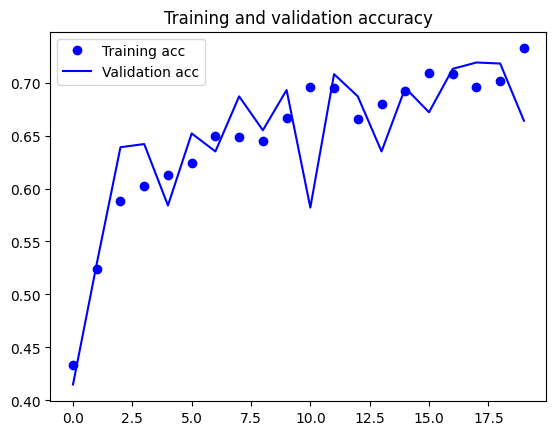

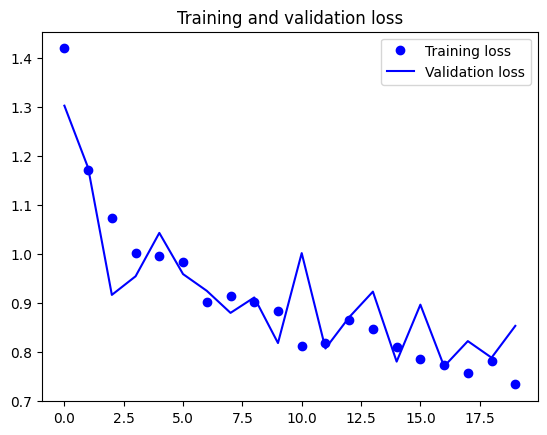

In [66]:
# plot the training and validation scores
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [67]:
# evaludate the model
# Evaluation

eval_test = model.evaluate(test_generator, steps=1000)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - acc: 0.4715 - loss: 1.1262
The test score (accuracy) is 52.89999842643738%


In [68]:
from keras.applications import ResNet50

conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [69]:
# from keras.applications import InceptionV3

# conv_base = InceptionV3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(150, 150, 3)
# )
# conv_base.summary()

In [70]:
# # initiate a pre-trained convolutional base VGG16
# from keras.applications import VGG16

# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))
# conv_base.summary()



In [71]:
# build the network
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # categorical classification

conv_base.trainable = False
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,805,189 (189.99 MB)

 Trainable params: 26,217,477 (100.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [72]:
# configure the model
from keras import optimizers
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer = 'rmsprop',
              metrics=['acc'])

# train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,     
      epochs=5,
      validation_data=valid_generator,
      validation_steps=50       # 1000/20
      )


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 686ms/step - acc: 0.3256 - loss: 8.3534 - val_acc: 0.4280 - val_loss: 1.3456
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 650ms/step - acc: 0.3376 - loss: 2.0856 - val_acc: 0.1690 - val_loss: 1.6708
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 776ms/step - acc: 0.3865 - loss: 1.5295 - val_acc: 0.4480 - val_loss: 1.3030
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 664ms/step - acc: 0.3948 - loss: 1.3869 - val_acc: 0.3870 - val_loss: 1.3288
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 664ms/step - acc: 0.4576 - loss: 1.2988 - val_acc: 0.3740 - val_loss: 1.3567


In [73]:
# evaludate the model
# Evaluation

eval_test = model.evaluate(test_generator, steps=1000)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - acc: 0.9765 - loss: 0.5510
The test score (accuracy) is 98.1000006198883%


In [77]:
model.save_weights('ResNet5098.weights.h5')
model.save('ResNet5098.keras')